In [82]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
from sklearn.cluster import KMeans
import os
import imageio
from PIL import Image

%matplotlib inline


In [83]:
def Initialization (foldername,topcolors):

    #Clothing part
    #foldername = "./fashion";
    #topcolors = 2 #the number of top colors we want to compare

    #iterate through folder and find kmeans data

    num_points = len(os.listdir(foldername))

    centerPoints = np.zeros((num_points,topcolors,3))
    
    count =0

    indiceList = []
    weightsList = []
    for item in os.listdir(foldername):
 
        image = imageio.imread(foldername+'/'+item)
    
        x = image.shape[0]
        y = image.shape[1]
        z = image.shape[2]
        
        indiceList.append([item])
        weights = np.ones((topcolors,1))

    
        newim = np.reshape(image,(x*y,z))

    
        kmeans = KMeans(n_clusters=topcolors, random_state=0).fit(newim)
        centers = kmeans.cluster_centers_  #cluster centers
        cluster_ids = kmeans.labels_
        for i in range(0,topcolors):
            vec = (cluster_ids == i)
            num = np.sum(vec)
            weights[i] = num/(x*y)
        
        weightsList.append(weights)
        
        order = np.argsort(weights,axis = None)
        
        centerPoints[count,:,:]=centers[order] #the top colors in the picture
        
        count = count+1
        
    return centerPoints,indiceList, weightsList
    
    
    
    
    
    
    



In [84]:
def Euclid_dist(x, y):

    ndim = x.shape[0];

    dist= np.sqrt(np.sum(np.square(x-y)))

        
    return dist
    raise NotImplementedError
    



def distanceCalc(centerPoints, weightsList):
    #centePoints is num*col*3
    num = centerPoints.shape[0]
    col = centerPoints.shape[1]
    FirstIm = np.zeros((3,1));
    SecondIm = np.zeros((3,1));
    distvec = np.zeros((num,num))
    dist = 0
    
    for i in range(0,num):
        for j in range(0,num):
            for k in range(0,col):
                FirstIm[0] = centerPoints[i,k,0];
                FirstIm[1] = centerPoints[i,k,1];
                FirstIm[2] = centerPoints[i,k,2];
                
                SecondIm[0] = centerPoints[j,k,0]
                SecondIm[1] = centerPoints[j,k,1]
                SecondIm[2] = centerPoints[j,k,2]
                
                weightMean = (weightsList[i][k]+weightsList[j][k])/2
                
                dist = dist + weightMean*Euclid_dist(FirstIm,SecondIm)
                
                
            distvec[i,j] = dist
            distvec[j,i] = dist
            dist = 0
            
            
            
    return distvec




def findGroup(WantedDist,distances):
    indices = np.argwhere(distances <= WantedDist)
    
    num = indices.shape[0]
    newvec = []
    
    for i in range(0,num):
        for j in range(0,num):
            if(indices[j,0] == i): #if first indice = i, then add second indices to newvec
                if (~np.any(newvec == indices[j,1])):
                    newvec.append(indices[j,1])
            
        if (newvec[-1]!=-1):
            newvec.append(-1)
    
    return newvec
    
      
    
def Clustering(foldername, topcolors,layers,maxClusternum):
    centerPoints, indiceList, weightsList = Initialization(foldername,topcolors)
    num = centerPoints.shape[0]
    col = centerPoints.shape[1]
    
    distmat = distanceCalc(centerPoints,weightsList)
    minDist = np.min(distmat)
    maxDist = np.max(distmat)
    
    
    count = 0
    totSum = np.zeros((1,col,3))
    tempWeights = np.zeros((1,col))
    newClusterNum = 0;
    
    tempCenterPoints = np.zeros((num,col,3))
    tempWeightsList = []
    prevstore = findGroup(minDist,distmat)
    
    Output = []
    
    tempList = []
    tempindiceList = []
    
    
    for radius in np.linspace(minDist,maxDist,layers):
        store =findGroup(radius,distmat)
        
        if(~np.array_equal(store ,prevstore)):
            for indices in store:
                if(indices != -1):
                    count = count+1
                    totSum = totSum + centerPoints[indices,:,:]
                    for i in range(0,len(weightsList[indices])):
                        tempWeights[0,i] = tempWeights[0,i]+weightsList[indices][i]
                    for item in indiceList[indices]:
                        
                        tempList.append(item)
                else:
                    compVec = np.zeros(totSum.shape)

                    if (~np.array_equal(compVec,totSum)):
                        tempCenterPoints[newClusterNum,:,:] = totSum/count
                        tempWeightsList.append(tempWeights[0]/count)
                        newClusterNum = newClusterNum + 1
                        tempindiceList.append(tempList)

                        
                    else:
                        newClusterNum = 0
                        
                    tempList=[]
                        
                    
                        
                    count = 0
                    totSum = np.zeros((1,col,3))
                    tempWeights = np.zeros((1,col))
                    
                    
                    
            centerPoints = tempCenterPoints[0:newClusterNum,:,:]
            weightsList = tempWeightsList
            
            tempCenterPoints = np.zeros((num,col,3))
            distmat = distanceCalc(centerPoints, weightsList)
            tempWeightsList = []
            Output.append(store)
            
            prevstore = store
            indiceList= tempindiceList
            tempindiceList = []
            
            if(newClusterNum <= maxClusternum):
                print("Im here")
                return indiceList
            
            newClusterNum = 0
            
        
        
            
            
            
                    
    return indiceList
                    
                    
    

                

In [94]:
def fileWrite(OutputData,foldername):
    picNums = os.listdir(foldername)
    count = 0
    #string = "Cluster "+str(0)+","
    string = "Cluster \n"
    clusterNum = len(OutputData)
    
    for i in range(0,clusterNum):
        string = string + "Cluster" + str(count) +","
        for j in OutputData[i]:
            string = string+j+","
                
        string = string + "\n"
        #string = string+"Cluster "+str(count)+","
        
        count = count+1
            
    file = open("OutputData.csv","w") 
    file.write(string)
    file.close()
    
    print("fileCreated")
        
    

In [100]:
fileWrite(OutputData,foldername)

fileCreated


In [101]:
foldername = "./fashion"
OutputData = Clustering(foldername,1,100,9)



Im here


Cluster0:


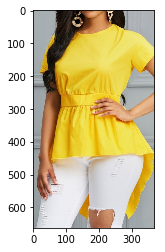

Cluster0:


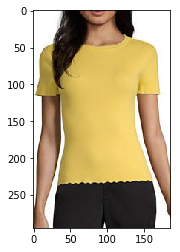

Cluster0:


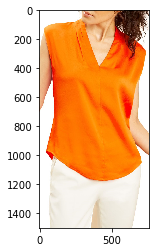

Cluster0:


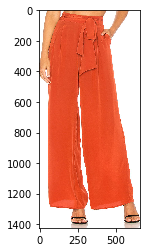

Cluster0:


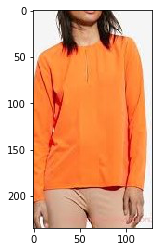

Cluster0:


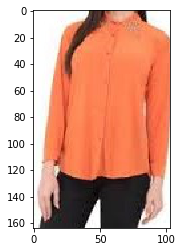

Cluster0:


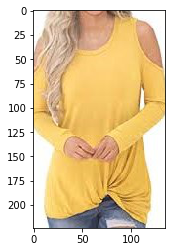

Cluster1:


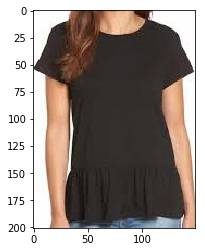

Cluster1:


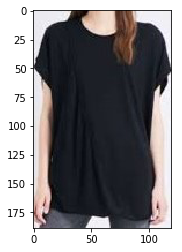

Cluster1:


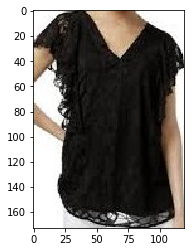

Cluster1:


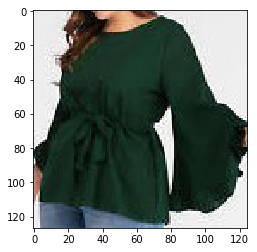

Cluster1:


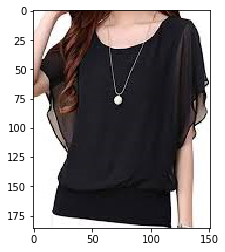

Cluster2:


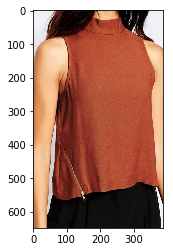

Cluster2:


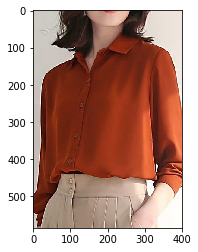

Cluster2:


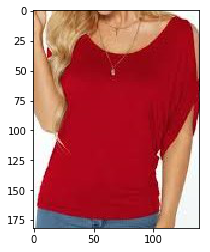

Cluster2:


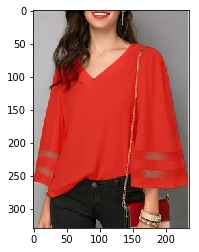

Cluster2:


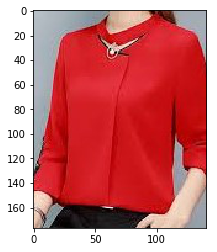

Cluster2:


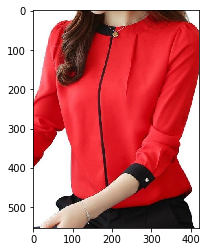

Cluster3:


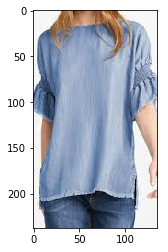

Cluster3:


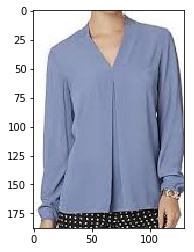

Cluster3:


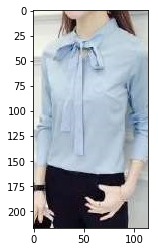

Cluster4:


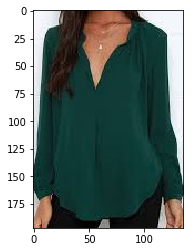

Cluster4:


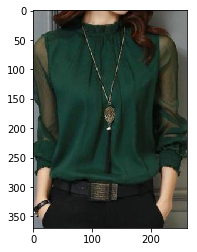

Cluster5:


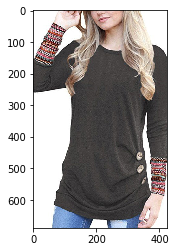

Cluster5:


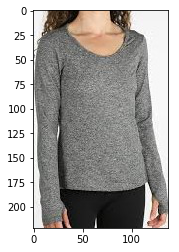

Cluster6:


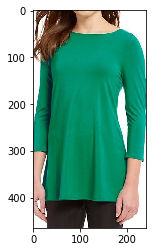

Cluster6:


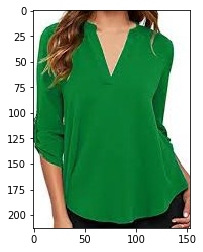

Cluster7:


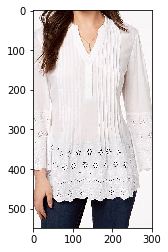

Cluster7:


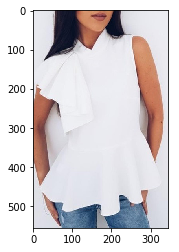

Cluster7:


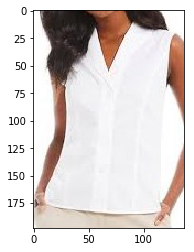

Cluster7:


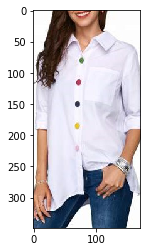

Cluster7:


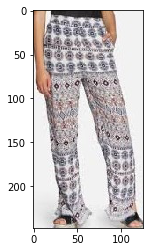

Cluster7:


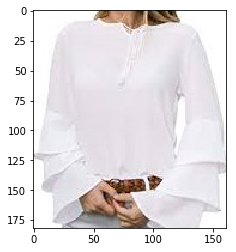

Cluster7:


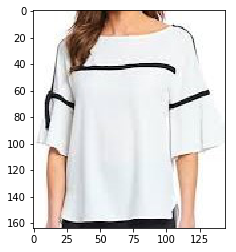

Cluster8:


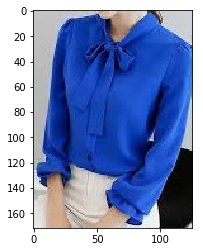

Cluster8:


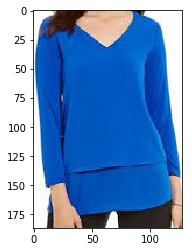

Cluster8:


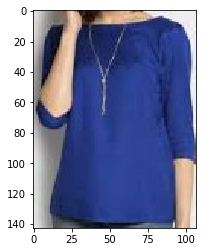

In [102]:
for i in range(0,len(OutputData)):
    for j in range(0, len(OutputData[i])):
        print("Cluster"+str(i)+":")
        img = im.imread("./fashion/" + str(OutputData[i][j]))
        img = plt.imshow(img)
        plt.show()